## Pair Statistics

Here we make 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

In [2]:
import pair_statistics_module as psm

In [3]:
# Use cell if wanting to reload modules while developing
#import importlib
#importlib.reload(psm)

In [4]:
ds = xr.open_dataset('data/gdp_subset_lon_-70_to_-30_lat_20_to_30.nc')
#ds = xr.open_dataset('data/gdp_subset_lon_-15_to_5_lat_-55_to_-35.nc')

In [5]:
ds.load()

<xarray.Dataset>
Dimensions:                (traj: 928, obs: 6140263)
Coordinates:
    ID                     (traj) int64 6070 6686 6687 ... 67208590 67209360
    lon                    (obs) float32 -30.0 -30.01 -30.01 ... -44.2 -44.2
    lat                    (obs) float32 21.43 21.43 21.43 ... 29.97 29.98 30.0
    time                   (obs) datetime64[ns] 2003-03-24T11:00:00 ... 2019-...
    ids                    (obs) int64 6070 6070 6070 ... 67209360 67209360
Dimensions without coordinates: traj, obs
Data variables: (12/54)
    rowsize                (traj) int64 9597 4644 5511 ... 10166 10073 10019
    location_type          (traj) int8 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
    WMO                    (traj) int32 1300517 4100553 ... 1402559 6203708
    expno                  (traj) int32 9325 6129 6129 6129 ... 2222 2222 2222
    deploy_date            (traj) datetime64[ns] 2002-09-06 ... 2019-02-08
    deploy_lon             (traj) float32 -17.7 -57.9 -61.57 ... -48.9 -46.1
    ...                     ...
    err_sst                (obs) float32 0.063 0.075 0.066 ... 0.014 0.014 0.014
    err_sst1               (obs) float32 0.019 0.018 0.018 ... 0.005 0.005 0.005
    err_sst2               (obs) float32 0.065 0.078 0.07 ... 0.013 0.012 0.012
    flg_sst                (obs) int8 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5
    flg_sst1               (obs) int8 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5
    flg_sst2               (obs) int8 4 2 2 4 4 4 4 4 4 4 ... 5 5 5 5 5 2 2 5 5
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-06-27T13:53:17.908246
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

In [6]:
dul = np.array([])
dut = np.array([])
dist = np.array([])

In [ ]:
%%time 
## takes about 15 mins, but time scale roughly linearly wiht number of samples
for year in range(2000, 2021):
    print(year)
    ds_yr = psm.retrieve_year(ds, year)
    trajs = psm.ds2trajstruct(ds_yr)
    traj_arrays = {}
    traj_arrays['lon_array'], traj_arrays['lat_array'], traj_arrays['u_array'], traj_arrays['v_array'] = psm.trajstruct2arrays(trajs, year)
    timepairs = psm.trajarrays2timepairs(traj_arrays, year)
    dul_year, dut_year, dist_year = psm.timepairs2list(timepairs, year)
    
    dul = np.append(dul, dul_year)
    dut = np.append(dut, dut_year)
    dist = np.append(dist, dist_year)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


In [ ]:
ds_pairs = xr.Dataset()

ds_pairs['dul'] = xr.DataArray(dul, dims=['pairs'])
ds_pairs['dut'] = xr.DataArray(dut, dims=['pairs'])
ds_pairs['dist'] = xr.DataArray(dist, dims=['pairs'])

In [ ]:
ds_pairs.to_netcdf('data/pairs_NAtl_lon_-70_to_-30_lat_20_to_30.nc')

In [13]:
ds_pairs.nbytes/1e9

3.538585848

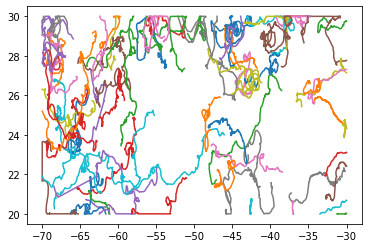

In [14]:
for i in range(len(trajs)):
    plt.plot(trajs[i].lon, trajs[i].lat)

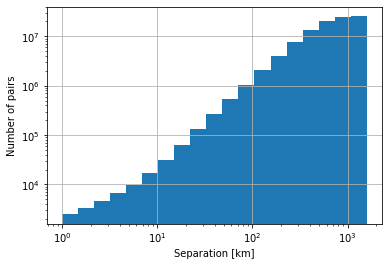

In [15]:
plt.hist(dist/1e3, bins=np.logspace(0, 3.2, 20));
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Separation [km]')
plt.ylabel('Number of pairs')
plt.grid()


In [16]:
dist_bin = np.logspace(3, 6, 18)
dist_axis = 0.5*(dist_bin[:-1] + dist_bin[1:])

In [17]:
dist_bin

array([   1000.        ,    1501.31072891,    2253.93390473,
          3383.85515343,    5080.21804691,    7626.98585902,
         11450.47569938,   17190.72201859,   25808.61540418,
         38746.75120456,   58170.91329374,   87332.61623828,
        131113.39374216,  196841.94472866,  295520.92352029,
        443668.73309786,  666084.62908092, 1000000.        ])

In [18]:
SF2_ll = np.NaN*np.ones_like(dist_axis)
SF2_tt = np.NaN*np.ones_like(dist_axis)
SF3_lll = np.NaN*np.ones_like(dist_axis)
SF3_ltt = np.NaN*np.ones_like(dist_axis)

for i in range(len(dist_axis)): 
    id = np.logical_and(dist>dist_bin[i], 
                        dist<=dist_bin[i+1])
    
    SF2_ll[i] = np.nanmean(dul[id]**2)
    SF2_tt[i] = np.nanmean(dut[id]**2)
    
    SF3_lll[i] = np.nanmean(dul[id]**3)
    SF3_ltt[i] = np.nanmean(dul[id]*(dut[id]**2))
    

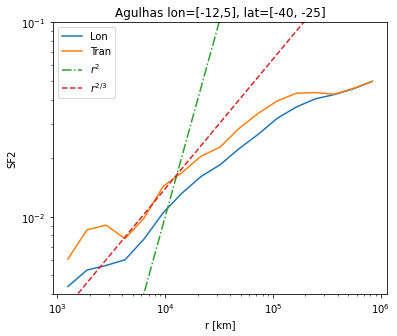

In [19]:
plt.figure(figsize=(6, 5))

plt.plot(dist_axis, SF2_ll, label='Lon')
plt.plot(dist_axis, SF2_tt, label='Tran')

plt.plot(dist_axis, 1e-10*dist_axis**2, '-.',  label= '$r^2$')
plt.plot(dist_axis, 3e-5*dist_axis**(2/3), '--', label= '$r^{2/3}$')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([4e-3,1e-1])
plt.xlabel('r [km]')
plt.ylabel('SF2')
plt.title('NAtl lon=[-70,5], lat=[-40, -25]')

plt.savefig('SF2.png')

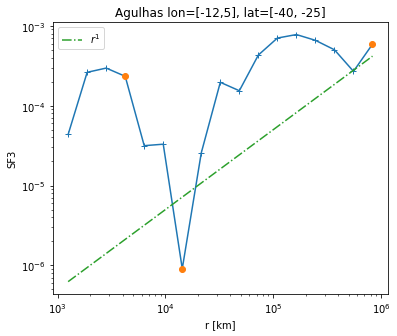

In [20]:
plt.figure(figsize=(6, 5))

plt.plot(dist_axis, np.abs(SF3_lll+SF3_ltt), '+-' )
plt.plot(dist_axis, -(SF3_lll+SF3_ltt) , 'o')
#plt.plot(dist_axis, SF3_ltt, label='Tran')

plt.plot(dist_axis, 5e-10*dist_axis**1, '-.',  label= '$r^1$')
#plt.plot(dist_axis, 3e-5*dist_axis**(2/3), '--', label= '$r^{2/3}$')

plt.xscale('log')
plt.yscale('log')
plt.legend()
#plt.ylim([1e-6,1e-3])
plt.xlabel('r [km]')
plt.ylabel('SF3')
plt.title('Agulhas lon=[-12,5], lat=[-40, -25]')

plt.savefig('SF3.png')